## DCF Model - Target Company

### I. Data Preparation 

In [3]:
# Load packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 
start_time = datetime.now() 
# datetime object containing current date and time
now = datetime.now()
# dt_string = now.strftime(“%d/%m/%Y %H:%M:%S”)
%matplotlib inline

In [18]:
# Read the Target Company's IS
# NOTE: numbers are in the "MM"
dcf_data = pd.read_csv("target_company_IS.csv")
dcf_data

,Unnamed: 0,2017,2018,2019,2020,2021
0,Revenue:,NaN,NaN,NaN,NaN,NaN
1,Patient Revenue:,8.4,7.7,6.7,8.0,8.3
2,Other Revenue:,0.6,0.9,2.2,0.9,0.2
3,Returns & Allowances:,-0.1,-0.2,-0.3,-0.1,-0.1
4,Total Net Revenue:,8.8,8.4,8.7,8.8,8.4
5,Cost of Goods Sold:,NaN,NaN,NaN,NaN,NaN
6,Dental Supplies and Lab:,1.8,1.2,1.3,1.3,1.2
7,Total COGS:,1.8,1.2,1.3,1.3,1.2
8,Gross Margin:,7.0,7.2,7.4,7.4,7.2
9,Operating Expenses:,NaN,NaN,NaN,NaN,NaN


### II. Project IS

In [19]:
# Create a panda series to save the total net revenue 
years = ['LTM 2021', '2022P', '2023P', '2024P', '2025P', '2026P']
total_revenue = pd.Series(index = years)
total_revenue['LTM 2021'] = dcf_data.iloc[4]['2021']
total_revenue

LTM 2021    8.4
2022P       NaN
2023P       NaN
2024P       NaN
2025P       NaN
2026P       NaN
dtype: float64

In [20]:
growth_rate = 0.1
for year in range(1, 6):
    total_revenue[year] = total_revenue[year - 1] * (1 + growth_rate)
total_revenue

LTM 2021     8.400000
2022P        9.240000
2023P       10.164000
2024P       11.180400
2025P       12.298440
2026P       13.528284
dtype: float64

In [21]:
# Save financial metrics 
EBITDA = dcf_data.iloc[22]['2021']
EBITDA_margin = dcf_data.iloc[22]['2021'] / dcf_data.iloc[4]['2021']
DA = dcf_data.iloc[21]['2021']
EBIT = dcf_data.iloc[20]['2021']
NWC_perc_Rev = 0.02
NWC = total_revenue * NWC_perc_Rev
change_in_NWC = NWC.shift(1) - NWC 
CapEx_perc_Rev = 0.02
CapEx = -(total_revenue * CapEx_perc_Rev)
tax_rate = 0.28
taxes = -EBIT * tax_rate
NOPAT = EBIT + taxes
unlevered_fcf = NOPAT + DA - change_in_NWC - CapEx
unlevered_fcf

LTM 2021         NaN
2022P       0.489600
2023P       0.509760
2024P       0.531936
2025P       0.556330
2026P       0.583163
dtype: float64

### III. Calculate DCF

In [22]:
# Define WACC, terminal growth to calculate the dcf 
WACC = 0.20
terminal_growth = 0.02
terminal_value = ((unlevered_fcf[-1] * (1 + terminal_growth)) / 
                 (WACC - terminal_growth))
discount_factors = [(1 / (1 + WACC)) ** i for i in range (1,6)]
dcf_value = (sum(unlevered_fcf[1:] * discount_factors) +
            terminal_value * discount_factors[-1])
dcf_value

2.900524691358026

### IV. Monte Carlo Simulation 

In [24]:
# Define the #s of monte carlo simulation to run 
nums_iterations = 1000

# create a function to take all the input and run the function based on the #s of interations defined
def monte_carlo_sim():
    
    # Calculate DCF value for each set of random inputs
    monte_carlo_output = []
    for i in range(nums_iterations):
        for year in range(1, 6):
            total_revenue[year] = total_revenue[year - 1] * (1 + growth_rate)      
        EBITDA = dcf_data.iloc[22]['2021']
        DA = dcf_data.iloc[21]['2021']
        EBIT = dcf_data.iloc[20]['2021']
        NWC = total_revenue * NWC_perc_Rev
        change_in_NWC = NWC.shift(1) - NWC
        CapEx = -(total_revenue * CapEx_perc_Rev)
        taxes = -EBIT * tax_rate
        NOPAT = EBIT + taxes
        unlevered_fcf = NOPAT + DA - change_in_NWC - CapEx

        
        # DCF valuation
        terminal_value = (unlevered_fcf[-1] * 1.02) / (WACC - 0.02)
        unlevered_fcf[-1] += terminal_value
        discount_factors = [(1 / (1 + WACC)) ** i for i in range (1,6)]
        dcf_value = sum(unlevered_fcf[1:] * discount_factors )
        monte_carlo_output.append(dcf_value)
    
    return monte_carlo_output

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.36 s


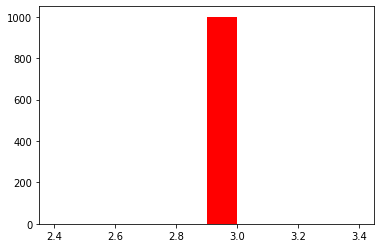

In [25]:
%time plt.hist(monte_carlo_sim(), bins=10, color='r')
plt.show()

This target company is worth around 2.9MM. 